In [1]:
import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train = pd.read_csv('./data/H1_cleaned.csv')
test = pd.read_csv('./data/H2_cleaned.csv')

In [3]:
train['is_canceled'].value_counts()

0    24142
1     9035
Name: is_canceled, dtype: int64

- As you can see, the cancelled cases is very small compared to booked cases
- This can be a problem, we'll look later

In [4]:
test['is_canceled'].value_counts()

0    43226
1    30213
Name: is_canceled, dtype: int64

### Feature Engineering

#### Label Encoder

In [5]:
df_le = train.copy()
le = LabelEncoder()

categoricals = [
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
]

for col in categoricals:
    df_le[col] = le.fit_transform(df_le[col])

#### Correlation

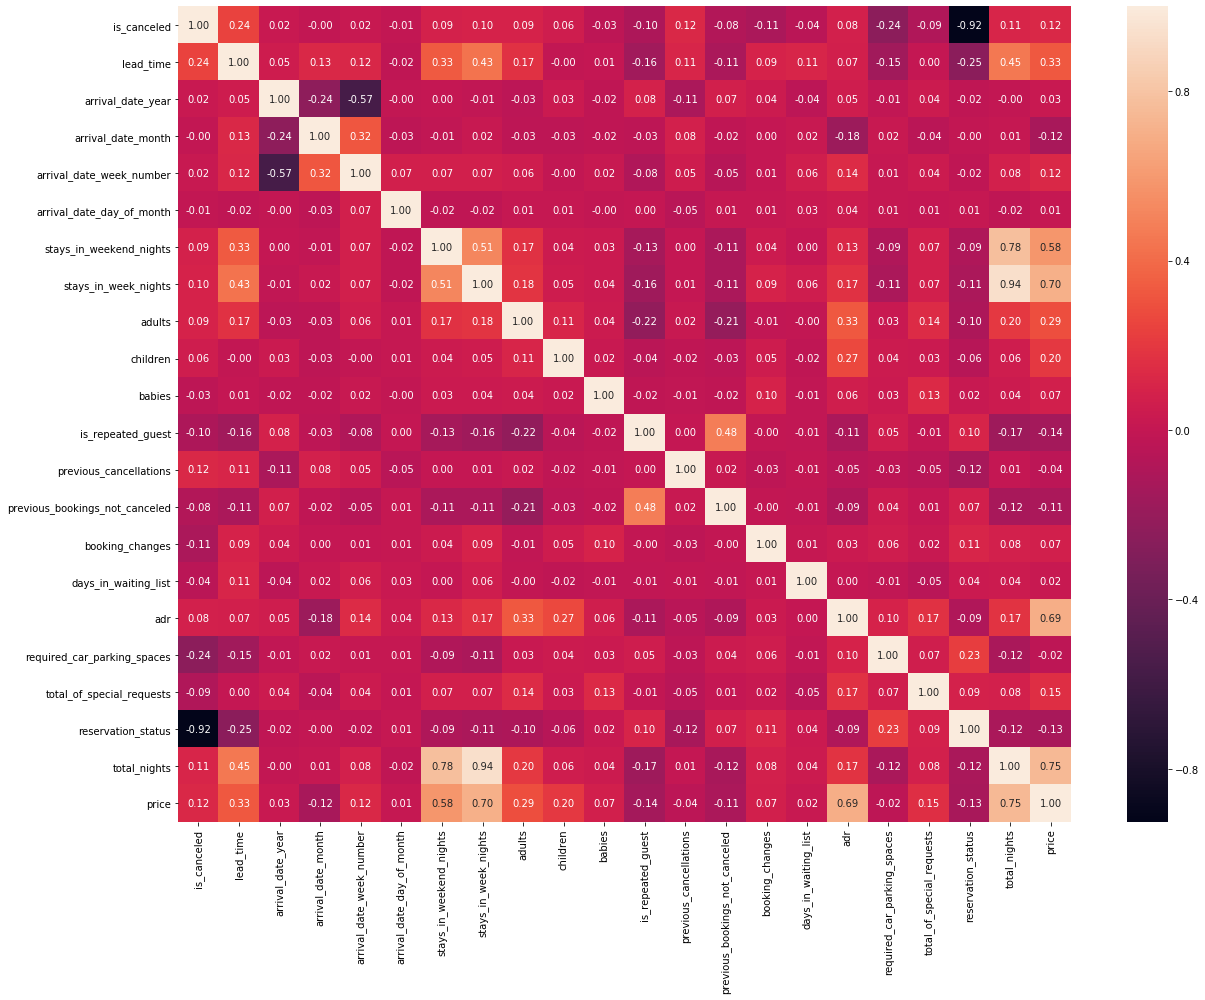

In [6]:
drop_cols = [
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'customer_type',
    'agent',
    'company',
]

plt.figure(figsize=(20, 15))
sns.heatmap(df_le.drop(drop_cols, axis=1).corr(), annot=True, fmt='.2f');

- There is high correlation between `reservation_status` and `is_canceled`
- And in the same, there is high correlation between `total_nights` and `stays_in_week_nights`
- And last one, between `total_nights` and `stays_in_weekend_nights`
- So, drop the `reservation_status`and `total_nights`
- And drop the `reservation_status_date` because of related between `reservation_status`

In [7]:
columns = [
    'reservation_status_date',
    'total_nights',
    'reservation_status',
]

train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)

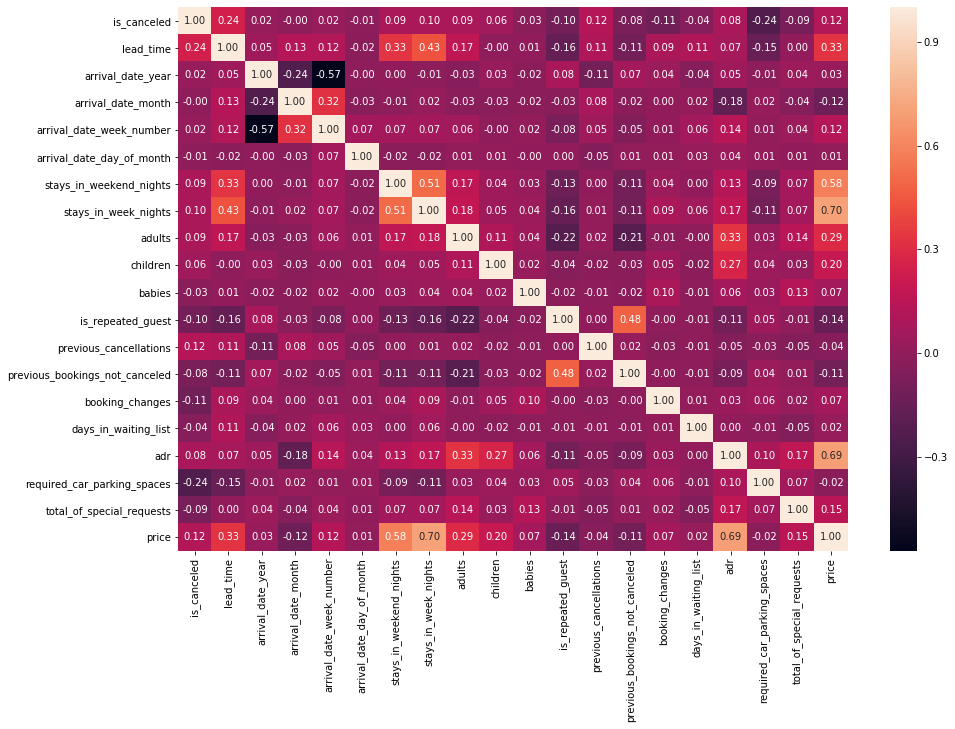

In [8]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_le.drop(drop_cols, axis=1).corr(), annot=True, fmt='.2f');

#### Dummy Variables vs Label Encoder

In [9]:
new_categoricals = [col for col in categoricals if col in train.columns]
df_hot = pd.get_dummies(data=train, columns=new_categoricals)
test_hot = pd.get_dummies(data=test, columns=new_categoricals)

In [10]:
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = train['is_canceled']

#### First Glance

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_hot, y, test_size=.2, random_state=42)

log = LogisticRegression().fit(X_train, y_train)
y_pred = log.predict(X_test)

In [12]:
accuracy_score(y_test, y_pred)

0.8661844484629295

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4825
           1       0.80      0.67      0.73      1811

    accuracy                           0.87      6636
   macro avg       0.84      0.81      0.82      6636
weighted avg       0.86      0.87      0.86      6636



- Accuracy score is very good but,
- As you can see, the prediction rate of cancelled bookings is lower
- Therefore, we'll increase the cancelled booking samples or decrease the booked booking samples

##### Feature Elimination

In [14]:
def select(X):
    selects = []
    
    selector = SelectKBest(chi2, k='all').fit(X, y)
    scores = selector.scores_
        
    q3 = np.quantile(scores, 0.75)
    q1 = np.quantile(scores, 0.25)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr

    for col, val in zip(X.columns, scores):
        cond1 = val > threshold
        cond2 = col in test_hot.columns or col in test.columns
        
        if cond1 and cond2:
            if col not in test_hot.columns:
                test_hot.loc[:, col] = 0
            selects.append(col)
        
    return selects

In [15]:
selects_hot = select(X_hot)
selects_le = select(X_le)

In [16]:
def compare():
    for is_le in [True, False]:
        method = 'label encoder'
        
        if is_le:
            selected = df_le[selects_le + ['is_canceled']]
        else:
            selected = df_hot[selects_hot + ['is_canceled']]
            method = 'dummy variables'
        
        # separate majority and minority classes
        major = selected[selected['is_canceled'] == 0]
        minor = selected[selected['is_canceled'] == 1]

        # downsample majority class
        downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

        # combine minority class with downsampled majority class
        df_new = pd.concat([downsampled, minor])
    
        X = df_new.drop('is_canceled', axis=1)
        y = df_new['is_canceled']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        log = LogisticRegression().fit(X_train, y_train)
        y_pred = log.predict(X_test)

        print(f'Accuracy for {method}: {accuracy_score(y_test, y_pred)}')
        print(f'Classification report for {method}:\n{classification_report(y_test, y_pred)}')

In [17]:
compare()

Accuracy for label encoder: 0.698671831765357
Classification report for label encoder:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      1806
           1       0.70      0.69      0.70      1808

    accuracy                           0.70      3614
   macro avg       0.70      0.70      0.70      3614
weighted avg       0.70      0.70      0.70      3614

Accuracy for dummy variables: 0.8323187603763144
Classification report for dummy variables:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1806
           1       0.83      0.83      0.83      1808

    accuracy                           0.83      3614
   macro avg       0.83      0.83      0.83      3614
weighted avg       0.83      0.83      0.83      3614



In [18]:
last = test_hot[selects_hot + ['is_canceled']]

X_last = last.drop('is_canceled', axis=1)
y_last = last['is_canceled']

In [19]:
selected = df_hot[selects_hot + ['is_canceled']]

In [20]:
# separate majority and minority classes
major = selected[selected['is_canceled'] == 0]
minor = selected[selected['is_canceled'] == 1]

# downsample majority class
downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([downsampled, minor])

# display new class counts
df_new['is_canceled'].value_counts()

1    9035
0    9035
Name: is_canceled, dtype: int64

In [21]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [22]:
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Modelling

In [24]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'./images/{name}_{part}.png')
        plt.show()

In [25]:
report = Report(X_test, y_test)

#### Logistic Regression

In [26]:
log = LogisticRegression().fit(X_train, y_train)

Accuracy score:

0.8323187603763144

Confusion Matrix:

[[1499  307]
 [ 299 1509]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1806
           1       0.83      0.83      0.83      1808

    accuracy                           0.83      3614
   macro avg       0.83      0.83      0.83      3614
weighted avg       0.83      0.83      0.83      3614



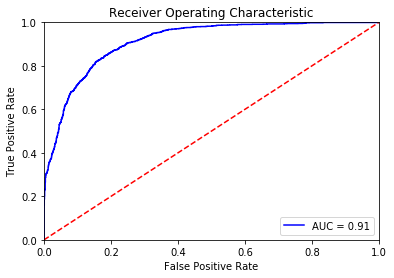

In [27]:
report.metrics(log)
report.plot_roc_curve(log)

In [28]:
cross_val_score(log, X_test, y_test, cv=10).mean()

0.824555961970449

#### Naive Bayes

In [29]:
nb = GaussianNB().fit(X_train, y_train)

Accuracy score:

0.7484781405644715

Confusion Matrix:

[[1335  471]
 [ 438 1370]]

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.74      0.75      1806
           1       0.74      0.76      0.75      1808

    accuracy                           0.75      3614
   macro avg       0.75      0.75      0.75      3614
weighted avg       0.75      0.75      0.75      3614



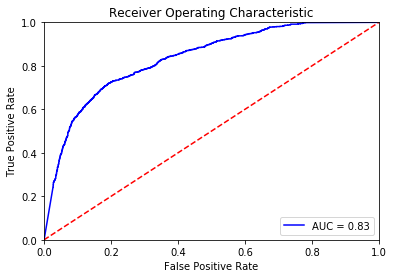

In [30]:
report.metrics(nb)
report.plot_roc_curve(nb)

In [31]:
cross_val_score(nb, X_test, y_test, cv=10).mean()

0.7415273462807935

#### KNN

In [32]:
knn = KNeighborsClassifier().fit(X_train, y_train)

In [33]:
knn = KNeighborsClassifier().fit(X_train, y_train)

Accuracy score:

0.6892639734366353

Confusion Matrix:

[[1229  577]
 [ 546 1262]]

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.68      0.69      1806
           1       0.69      0.70      0.69      1808

    accuracy                           0.69      3614
   macro avg       0.69      0.69      0.69      3614
weighted avg       0.69      0.69      0.69      3614



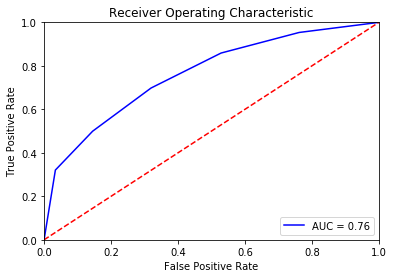

In [34]:
report.metrics(knn)
report.plot_roc_curve(knn)

In [35]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6248256412087698

- Model Tuning

In [36]:
knn_params = {'n_neighbors': range(1, 11)}

In [37]:
params = {
    'estimator': knn,
    'param_grid': knn_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
knn_cv = GridSearchCV(**params)

In [38]:
_ = knn_cv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.7s finished


In [39]:
knn_cv.best_params_

{'n_neighbors': 1}

In [40]:
knn = KNeighborsClassifier(**knn_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.7011621472053127

Confusion Matrix:

[[1230  576]
 [ 504 1304]]

Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.68      0.69      1806
           1       0.69      0.72      0.71      1808

    accuracy                           0.70      3614
   macro avg       0.70      0.70      0.70      3614
weighted avg       0.70      0.70      0.70      3614



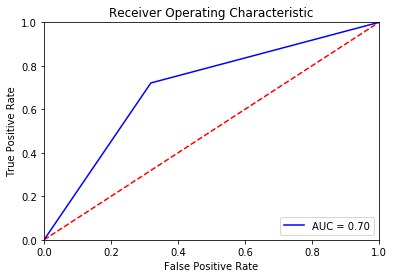

In [41]:
report.metrics(knn)
report.plot_roc_curve(knn, save=True)

In [42]:
cross_val_score(knn, X_test, y_test, cv=10).mean()

0.6204018916147594

#### Decision Tree

In [43]:
cart = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)

Accuracy score:

0.7324294410625346

Confusion Matrix:

[[1537  269]
 [ 698 1110]]

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.85      0.76      1806
           1       0.80      0.61      0.70      1808

    accuracy                           0.73      3614
   macro avg       0.75      0.73      0.73      3614
weighted avg       0.75      0.73      0.73      3614



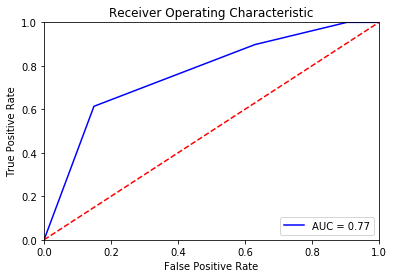

In [44]:
report.metrics(cart)
report.plot_roc_curve(cart)

In [45]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.7548615000960772

- Model Tuning

In [46]:
cart_params = {
    'max_depth': range(5, 25, 5),
    'min_samples_split' : range(2, 50), 
}

In [47]:
params = {
    'estimator': cart,
    'param_grid': cart_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
cart_cv = GridSearchCV(**params)

In [48]:
_ = cart_cv.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 678 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   37.6s finished


In [49]:
cart_cv.best_params_

{'max_depth': 5, 'min_samples_split': 2}

In [50]:
cart = DecisionTreeClassifier(**cart_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8350857775318207

Confusion Matrix:

[[1414  392]
 [ 204 1604]]

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.78      0.83      1806
           1       0.80      0.89      0.84      1808

    accuracy                           0.84      3614
   macro avg       0.84      0.84      0.83      3614
weighted avg       0.84      0.84      0.83      3614



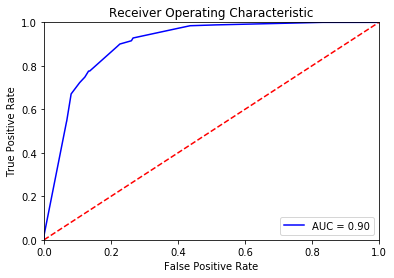

In [51]:
report.metrics(cart)
report.plot_roc_curve(cart, save=True)

In [52]:
cross_val_score(cart, X_test, y_test, cv=10).mean()

0.837856280470489

#### Random Forests

In [53]:
rf = RandomForestClassifier().fit(X_train, y_train)

Accuracy score:

0.8716104039845047

Confusion Matrix:

[[1581  225]
 [ 239 1569]]

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1806
           1       0.87      0.87      0.87      1808

    accuracy                           0.87      3614
   macro avg       0.87      0.87      0.87      3614
weighted avg       0.87      0.87      0.87      3614



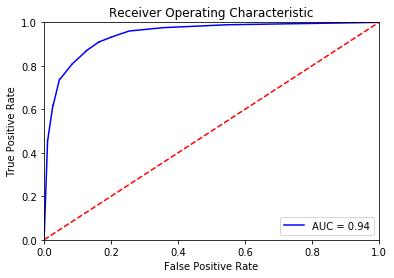

In [54]:
report.metrics(rf)
report.plot_roc_curve(rf)

In [55]:
cross_val_score(rf, X_test, y_test, cv=10).mean()

0.8417329046421422

- Model Tuning

In [56]:
rf_params = {
    'max_depth': [5, 10, 15, 20],
    'max_features': [2, 3, 5],
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [5, 10, 15],
}

In [57]:
params = {
    'estimator': rf,
    'param_grid': rf_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
rf_cv = GridSearchCV(**params)

In [58]:
_ = rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 12.1min finished


In [59]:
rf_cv.best_params_

{'max_depth': 20,
 'max_features': 5,
 'min_samples_split': 5,
 'n_estimators': 1000}

In [60]:
rf = RandomForestClassifier(**rf_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8765910348644161

Confusion Matrix:

[[1558  248]
 [ 198 1610]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1806
           1       0.87      0.89      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



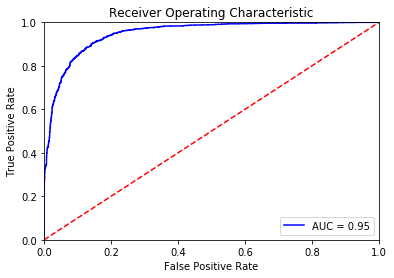

In [61]:
report.metrics(rf)
report.plot_roc_curve(rf, save=True)

In [62]:
cross_val_score(rf, X_test, y_test, cv=10).mean()

0.8591499849507456

#### Gradient Boosting Machines

In [63]:
gbm = GradientBoostingClassifier().fit(X_train, y_train)

Accuracy score:

0.863032650802435

Confusion Matrix:

[[1500  306]
 [ 189 1619]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1806
           1       0.84      0.90      0.87      1808

    accuracy                           0.86      3614
   macro avg       0.86      0.86      0.86      3614
weighted avg       0.86      0.86      0.86      3614



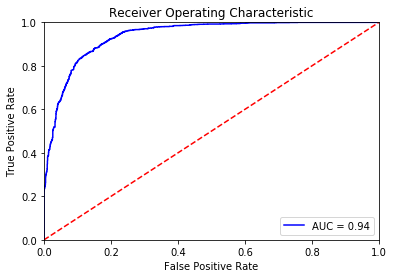

In [64]:
report.metrics(gbm)
report.plot_roc_curve(gbm)

In [65]:
cross_val_score(gbm, X_test, y_test, cv=10).mean()

0.8544630689595948

- Model Tuning

In [66]:
gbm_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [67]:
params = {
    'estimator': gbm,
    'param_grid': gbm_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
gbm_cv = GridSearchCV(**params)

In [68]:
_ = gbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 48.7min finished


In [69]:
gbm_cv.best_params_

{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 500}

In [70]:
gbm = GradientBoostingClassifier(**gbm_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8821250691754289

Confusion Matrix:

[[1560  246]
 [ 180 1628]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1806
           1       0.87      0.90      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



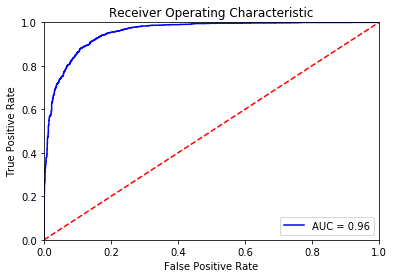

In [71]:
report.metrics(gbm)
report.plot_roc_curve(gbm, save=True)

In [72]:
cross_val_score(gbm, X_test, y_test, cv=10).mean()

0.8539182604422271

#### XGBoost

In [73]:
xgb = XGBClassifier().fit(X_train, y_train)

Accuracy score:

0.8635860542335363

Confusion Matrix:

[[1494  312]
 [ 181 1627]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1806
           1       0.84      0.90      0.87      1808

    accuracy                           0.86      3614
   macro avg       0.87      0.86      0.86      3614
weighted avg       0.87      0.86      0.86      3614



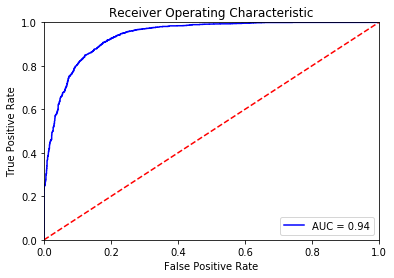

In [74]:
report.metrics(xgb)
report.plot_roc_curve(xgb)

In [75]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.859997130438775

- Model Tuning

In [76]:
xgb_params = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
}

In [77]:
params = {
    'estimator': xgb,
    'param_grid': xgb_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
xgb_cv = GridSearchCV(**params)

In [78]:
_ = xgb_cv.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 32.6min finished


In [79]:
xgb_cv.best_params_

{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}

In [80]:
xgb = XGBClassifier(**xgb_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.8790813503043718

Confusion Matrix:

[[1550  256]
 [ 181 1627]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1806
           1       0.86      0.90      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



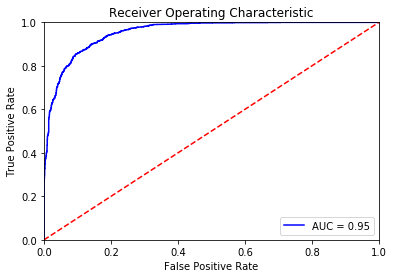

In [81]:
report.metrics(xgb)
report.plot_roc_curve(xgb, save=True)

In [82]:
cross_val_score(xgb, X_test, y_test, cv=10).mean()

0.8533488842295716

#### Light GBM

In [83]:
lgbm = LGBMClassifier().fit(X_train, y_train)

Accuracy score:

0.8796347537354732

Confusion Matrix:

[[1555  251]
 [ 184 1624]]

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1806
           1       0.87      0.90      0.88      1808

    accuracy                           0.88      3614
   macro avg       0.88      0.88      0.88      3614
weighted avg       0.88      0.88      0.88      3614



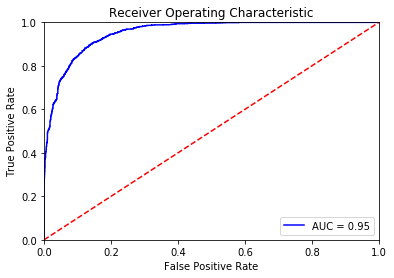

In [84]:
report.metrics(lgbm)
report.plot_roc_curve(lgbm)

In [85]:
cross_val_score(lgbm, X_test, y_test, cv=10).mean()

0.8569415791344213

- Model Tuning

In [86]:
lgbm_params = {
    'n_estimators': [100, 500, 1000, 2000],
    'subsample': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.02, 0.05],
    'min_child_samples': [5, 10, 20],
}

In [87]:
params = {
    'estimator': lgbm,
    'param_grid': lgbm_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
lgbm_cv = GridSearchCV(**params)

In [88]:
_ = lgbm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 29.0min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 33.2min finished


In [89]:
lgbm_cv.best_params_

{'learning_rate': 0.02,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 100,
 'subsample': 0.6}

In [90]:
lgbm = LGBMClassifier(**lgbm_cv.best_params_).fit(X_train, y_train)

Accuracy score:

0.853901494189264

Confusion Matrix:

[[1438  368]
 [ 160 1648]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.80      0.84      1806
           1       0.82      0.91      0.86      1808

    accuracy                           0.85      3614
   macro avg       0.86      0.85      0.85      3614
weighted avg       0.86      0.85      0.85      3614



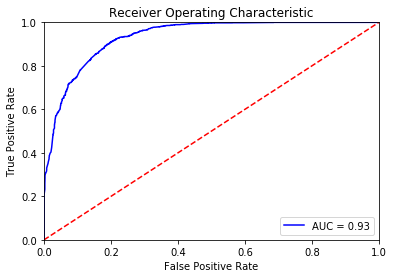

In [91]:
report.metrics(lgbm)
report.plot_roc_curve(lgbm, save=True)

In [92]:
cross_val_score(lgbm, X_test, y_test, cv=10).mean()

0.852802536777147

### Final

In [93]:
Xtr_last, Xte_last, ytr_last, yte_last = train_test_split(X_last, y_last, test_size=.2, random_state=42)

RandomForestClassifier
Accuracy score:

0.8545070806100218

Confusion Matrix:

[[8178  484]
 [1653 4373]]

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      8662
           1       0.90      0.73      0.80      6026

    accuracy                           0.85     14688
   macro avg       0.87      0.83      0.84     14688
weighted avg       0.86      0.85      0.85     14688



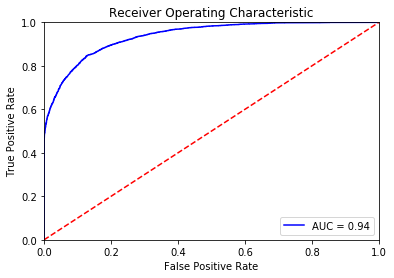

GradientBoostingClassifier
Accuracy score:

0.8815359477124183

Confusion Matrix:

[[7967  695]
 [1045 4981]]

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      8662
           1       0.88      0.83      0.85      6026

    accuracy                           0.88     14688
   macro avg       0.88      0.87      0.88     14688
weighted avg       0.88      0.88      0.88     14688



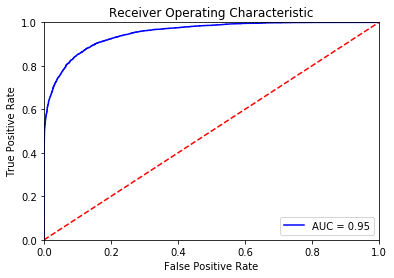

XGBClassifier
Accuracy score:

0.8637663398692811

Confusion Matrix:

[[7923  739]
 [1262 4764]]

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.91      0.89      8662
           1       0.87      0.79      0.83      6026

    accuracy                           0.86     14688
   macro avg       0.86      0.85      0.86     14688
weighted avg       0.86      0.86      0.86     14688



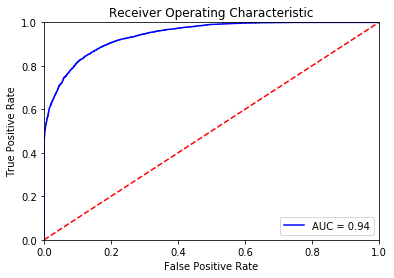

LGBMClassifier
Accuracy score:

0.8111383442265795

Confusion Matrix:

[[7998  664]
 [2110 3916]]

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      8662
           1       0.86      0.65      0.74      6026

    accuracy                           0.81     14688
   macro avg       0.82      0.79      0.80     14688
weighted avg       0.82      0.81      0.81     14688



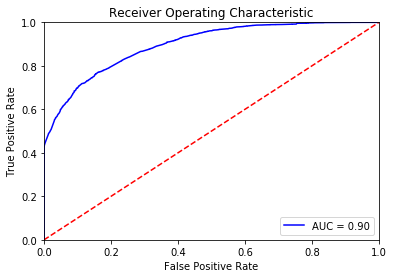

In [94]:
report = Report(Xte_last, yte_last)

params = {
    'RandomForestClassifier': {
        'max_depth': 20,
        'max_features': 5,
        'min_samples_split': 5,
        'n_estimators': 1000,
    },
    'GradientBoostingClassifier': {
        'max_depth': 10, 
        'min_samples_split': 10, 
        'n_estimators': 500,
    },
    'XGBClassifier': {
        'max_depth': 10, 
        'min_samples_split': 2, 
        'n_estimators': 100,
    },
    'LGBMClassifier': {
        'learning_rate': 0.02,
        'max_depth': 5,
        'min_child_samples': 20,
        'n_estimators': 100,
        'subsample': 0.6,
    }
}

rf = RandomForestClassifier(**params['RandomForestClassifier'])
gbm = GradientBoostingClassifier(**params['GradientBoostingClassifier'])
xgb = XGBClassifier(**params['XGBClassifier'])
lgbm = LGBMClassifier(**params['LGBMClassifier'])

for model in [rf, gbm, xgb, lgbm]:
    print(model.__class__.__name__)
    _ = model.fit(Xtr_last, ytr_last)
    report.metrics(model)
    report.plot_roc_curve(model, part='h2', save=True)